In [1]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')
                    img = img.resize((224, 224))  
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)
            except (IOError, UnidentifiedImageError) as e:
                print(f"Skipping file {img_path}: {e}")
    return np.array(images), np.array(labels)

train_folder = 'multiclassCNN/train'
test_folder = 'multiclassCNN/test'

x_train, y_train = load_images_from_folder(train_folder)
x_test, y_test = load_images_from_folder(test_folder)

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


2024-09-01 18:09:14.101293: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:

model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20, validation_data=(x_test, y_test))

model.evaluate(x_test, y_test)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


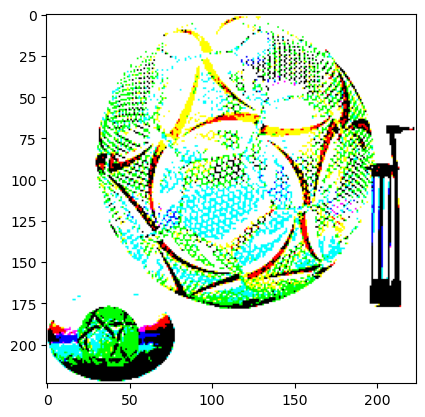

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Predicted Class: football, Actual Class: football


In [3]:

idx2 = random.randint(0, len(x_test) - 1)
plt.imshow(x_test[idx2])
plt.show()

y_pred = model.predict(x_test[idx2, :].reshape(1, 224, 224, 3))
predicted_class_idx = np.argmax(y_pred)

class_names = sorted([d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))])

predicted_class_name = class_names[predicted_class_idx]
actual_class_name = class_names[np.argmax(y_test[idx2])]

print(f"Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")
